In [1]:
from datasets import load_dataset

In [2]:
import gradio as gr
print(gr.__version__)

3.45.0


In [39]:
minds = load_dataset("PolyAI/minds14", name="ko-KR", split="train")

example = minds[0]

print(type(minds.features["intent_class"]))
print(example['path']) 
print(example['transcription'])
print(example['intent_class'])

<class 'datasets.features.features.ClassLabel'>
/storage/hf-datasets-cache/all/datasets/90720017063314-config-parquet-and-info-PolyAI-minds14-0f8c9bcc/downloads/extracted/73ab7f9ade76d3035add3081ab277e5bae46f3dbe75008135fea9e528746677a/ko-KR~ATM_LIMIT/602bef265f67b421554f65e7.wav
app Manager 하고 싶은데 최대 금액이 얼마인지요
3


In [4]:
from datasets import load_dataset_builder
dataset_builder = load_dataset_builder("PolyAI/minds14", name="ko-KR")
print(dataset_builder.cache_dir)

/home/ubuntu/.cache/huggingface/datasets/PolyAI___minds14/ko-KR/1.0.0/3a0bb29c446edbb0c461b27706cee1f3862191b8


In [34]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'atm_limit'

In [6]:
#columns_to_remove = ["lang_id", "english_transcription"]
#minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 592
})

In [35]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 592
})

In [8]:
#!chmod +x /usr/local/lib/python3.8/dist-packages/gradio/frpc_linux_amd64_v0.2

In [40]:
import gradio as gr

def generate_audio(idx):
    #example = minds.shuffle()[0]
    example = minds[idx]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"]) + ": " + example['transcription']


with gr.Blocks() as demo:
    with gr.Column():
        for idx in range(5):
            audio, label = generate_audio(idx)
            output = gr.Audio(audio, label=label)

demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1acb2d4bf22f81341a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1acb2d4bf22f81341a.gradio.live


In [41]:
#!pip install jinja2==3.0.1

8000


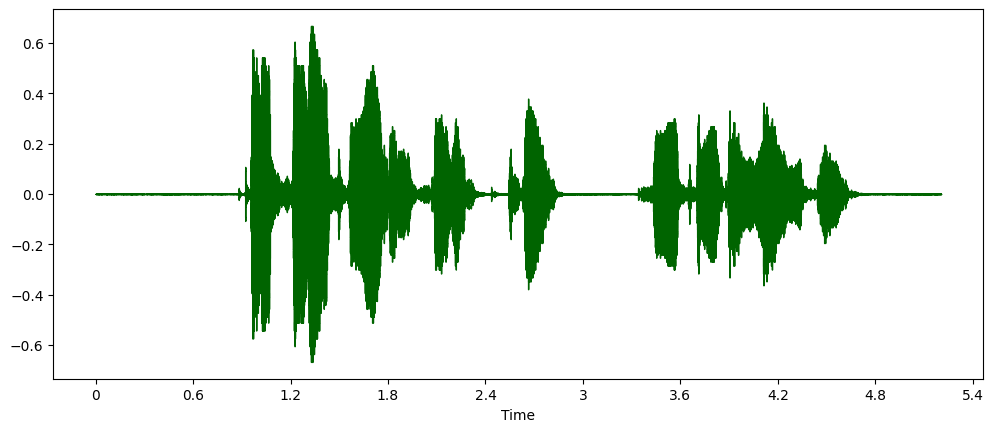

In [11]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

print(sampling_rate)

plt.figure().set_figwidth(12)
#librosa.display.waveshow(array, sr=sampling_rate, color="orange")
librosa.display.waveshow(array, sr=sampling_rate,color="darkgreen" )

## resample the audio examples 

In [42]:
from datasets import Audio

#set the sampling rate to 16kHz
minds = minds.cast_column("audio", Audio(sampling_rate=32_000))

In [13]:
minds[0]

{'path': '/storage/hf-datasets-cache/all/datasets/90720017063314-config-parquet-and-info-PolyAI-minds14-0f8c9bcc/downloads/extracted/73ab7f9ade76d3035add3081ab277e5bae46f3dbe75008135fea9e528746677a/ko-KR~ATM_LIMIT/602bef265f67b421554f65e7.wav',
 'audio': {'path': '602bef265f67b421554f65e7.wav',
  'array': array([ 2.45040166e-04,  1.78244198e-04, -1.80276402e-06, ...,
          5.53574704e-04,  4.92824474e-04,  2.39125075e-04]),
  'sampling_rate': 16000},
 'transcription': 'app Manager 하고 싶은데 최대 금액이 얼마인지요',
 'intent_class': 3}

In [ ]:
with gr.Blocks() as demo:
    with gr.Column():
        for idx in range(5):
            audio, label = generate_audio(idx)
            output = gr.Audio(audio, label=label)

demo.launch(debug=True, share=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://033d8c330e52e870e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [14]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

def calc_duration(minds):

    duration_seconds = []
    num_samples_too_long = 0
    #audio_data, sample_rate = librosa.load(audio_path, sr=None, mono=False)  # Use sr=None to preserve the original sample rate and mono=False to preserve stereo channels
    for audio_data in minds["audio"]:
        # Calculate the number of samples
        num_samples = len(audio_data["array"])   
        num_channel = 1
        sample_rate = audio_data["sampling_rate"]
        duration = num_samples / (sample_rate *  num_channel)
        #print(num_samples, num_channel, sample_rate, f"Duration of the audio file: {duration:.2f} seconds")

        if(duration > MAX_DURATION_IN_SECONDS): 
            num_samples_too_long += 1
            print(f" {num_samples_too_long}th sample: {duration:.2f} seconds")
        
        # Calculate the duration in minutes
        duration_seconds.append(duration)
    print(f"No. of samples_after_filtered: {len(minds) - num_samples_too_long }")
    
    return duration_seconds


In [15]:
# use librosa to get example's duration from the audio file
# new_column = [librosa.get_duration(path=x) for x in minds["path"]]
# In case it does not work, use a quick and dirty fix
new_column = calc_duration(minds)

minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

 1th sample: 24.49 seconds
 2th sample: 50.16 seconds
 3th sample: 24.15 seconds
 4th sample: 29.35 seconds
 5th sample: 26.66 seconds
 6th sample: 26.62 seconds
 7th sample: 26.62 seconds
 8th sample: 44.95 seconds
 9th sample: 28.84 seconds
 10th sample: 21.76 seconds
 11th sample: 20.53 seconds
 12th sample: 50.86 seconds
 13th sample: 24.41 seconds
 14th sample: 31.23 seconds
 15th sample: 62.88 seconds
 16th sample: 25.60 seconds
 17th sample: 36.18 seconds
 18th sample: 24.92 seconds
 19th sample: 47.19 seconds
 20th sample: 47.10 seconds
 21th sample: 62.29 seconds
 22th sample: 44.89 seconds
 23th sample: 24.66 seconds
 24th sample: 20.39 seconds
 25th sample: 25.17 seconds
 26th sample: 22.70 seconds
 27th sample: 20.57 seconds
 28th sample: 21.85 seconds
 29th sample: 55.72 seconds
No. of samples_after_filtered: 563


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 563
})

In [16]:
new_column = calc_duration(minds)

No. of samples_after_filtered: 563


## [Pre-processing audio data](https://github.com/kimdesok/Huggingface_Audio_Course/blob/main/Huggingface-Audio_dataset.ipynb)
references: UNIT 1. WORKING WITH AUDIO DATA

>* "The requirements for the input features may vary from one model to another — they depend on the model’s architecture, and the data it was pre-trained with."

>* 'Transformers offer a feature extractor class that can convert raw audio data into the input features the model expects."

In [17]:
# Working with Whisper dataset to transform that into mel spectrogram data
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [18]:
feature_extractor

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [19]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [20]:
# Data preparation
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 563
})

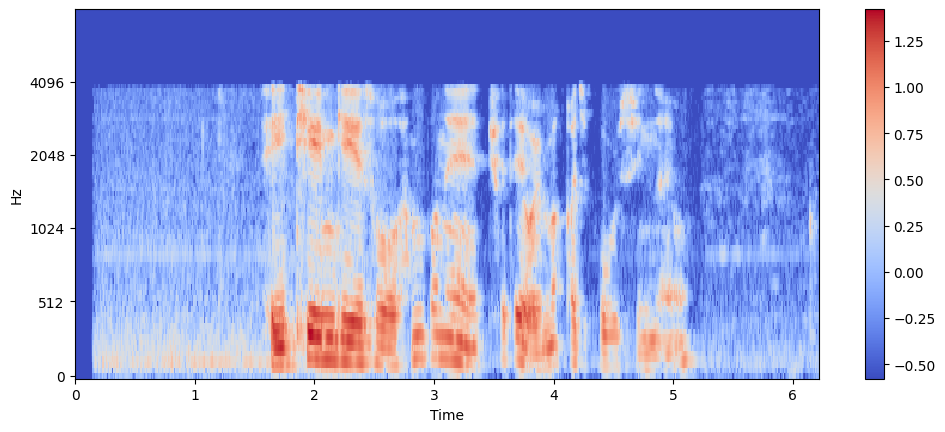

In [25]:
import numpy as np

example = minds[3]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [22]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

2024-01-20 14:39:32.367623: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

## Streaming audio data

> "Streaming mode can take your research to the next level: not only are the biggest datasets accessible to you, but you can easily evaluate systems over multiple datasets in one go without worrying about your disk space."

In [ ]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN --add-to-git-credential 

In [28]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for speechcolab/gigaspeech contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/speechcolab/gigaspeech
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [29]:
next(iter(gigaspeech["train"]))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}

In [30]:
#Preview
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)

[{'segment_id': 'YOU0000000315_S0000660',
  'speaker': 'N/A',
  'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
  'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
   'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
          0.00036621]),
   'sampling_rate': 16000},
  'begin_time': 2941.89,
  'end_time': 2945.07,
  'audio_id': 'YOU0000000315',
  'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
  'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
  'source': 2,
  'category': 24,
  'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'},
 {'segment_id': 'AUD0000001043_S0000775',
  'speaker': 'N/A',
  'text': 'SIX TOMATOES <PERIOD>',
  'audio': {'path': 'xs_chunks_0000/AUD0000001043_S0000775.wav',
   'array': array([ 1.43432617e-03,  1.37329102e-03,  1.31225586e-03, ...,
          -6.10351562e-05, -1.22070312e-04, -1.83105469e-04]),
   'sampling_rate': 16000},
 